In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import csv
import sys
import numpy as np
import base64
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

In [2]:
def getdataloaders(data,train_batch_size=50,test_batch_size=50):
    np.random.shuffle(data.T)
    train_data1 = data[:,:200000]
    test_data1 = data[:,200000:]
    
    #creating train batches
    num_batches_train = int(train_data1.shape[1]/train_batch_size)
    train_data= np.empty([num_batches_train,train_data1.shape[0],train_batch_size])
    for idx in range (0, num_batches_train):
        train_data[idx,:,:]=train_data1[:,idx*train_batch_size:(idx + 1)*train_batch_size]
    
    #creating test batches
    num_batches_test = int(test_data1.shape[1]/test_batch_size)
    test_data =np.empty([num_batches_test,test_data1.shape[0],test_batch_size])
    for idx in range (0, num_batches_test):
        test_data[idx,:,:]=test_data1[:,idx*test_batch_size:(idx + 1)*test_batch_size]
    
    return train_data,test_data

In [3]:
def cal_accuracy(target,output):
    correct_count = 0;
    
    for i in range (0,target.size(0)):
        if(output[i]>0.5):
            result =1 
        else:
            result =0
        if(target[i] == result):
            correct_count += 1
    accuracy = correct_count/target.size(0)
    
    return accuracy,correct_count
    
    

In [4]:
class network(nn.Module):
    def __init__(self,input_nodes,hidden_nodes1,hidden_nodes2,output_node):
        super(network,self).__init__()
        self.fc1 = nn.Linear(input_nodes,hidden_nodes1)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.bn1 = nn.BatchNorm1d(num_features=hidden_nodes1)
        
        self.fc2 = nn.Linear(hidden_nodes1,hidden_nodes2)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.bn2 = nn.BatchNorm1d(num_features = hidden_nodes2)
        
        self.fc3 = nn.Linear(hidden_nodes2,output_nodes)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        self.out_act = nn.Sigmoid();
        
    def forward(self,X):
        X = F.relu(self.bn1(self.fc1(X)))
        X = self.fc2(X)
        X = F.dropout2d(X,p=0.1)
        X = F.relu(X)
        X = self.fc3(X)
        out = self.out_act(X)
        return out
        
    

In [5]:
def train(trainloader, optimizer, criterion, epoch, net):
    net.train()
    train_loss_sum = 0
    total_correct_count = 0
    total_accuracy = 0 
    for  idx in range(trainloader.size(0)):
        target = trainloader[idx,47,:].reshape(trainloader.size(2)).float().reshape(trainloader.size(2),1)
        input_vectors = trainloader[idx,:47,:].float().t()
        output = net.forward(input_vectors)
        loss = criterion(output,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += float(loss)
        batch_accuracy,batch_corr_count = cal_accuracy(target,output)
        total_accuracy += batch_accuracy
    avg_acc = total_accuracy/trainloader.size(0)
    train_loss = train_loss_sum/trainloader.size(0)
    print("Epoch No." , epoch, " Train Loss" ,train_loss," Avg Accuracy ",avg_acc*100,"%")
    return train_loss


def test(testloader,criterion,epoch,net):
    net.eval()
    test_loss_sum = 0
    total_correct_count = 0
    total_accuracy = 0 
    for idx in range(testloader.size(0)):
        target = testloader[idx,47,:].reshape(testloader.size(2)).float().reshape(testloader.size(2),1)
        input_vectors = testloader[idx,:47,:].float().t()
        output = net.forward(input_vectors)
        loss = criterion(output,target.float())
        test_loss_sum += float(loss)
        batch_accuracy,batch_corr_count = cal_accuracy(target,output)
        total_accuracy += batch_accuracy
    test_loss = test_loss_sum/testloader.size(0)
    avg_acc = total_accuracy/testloader.size(0)
    print("Epoch No." , epoch, " Test Loss" ,test_loss," Avg Accuracy ",avg_acc*100,"%")
    print(" ")
    return test_loss
        
        
    

In [6]:
def plot_loss(x,y):
    plt.plot(x,y)
    plt.show()

In [9]:
input_nodes = 47
hidden_nodes1 = 50
hidden_nodes2 = 30
output_nodes = 1
batch_number = 50
learning_rate = 0.001
epochs = 30

data=np.load("../data/data_float360_8.npy")
train_data,test_data = getdataloaders(data,50,10)
trainloader = torch.from_numpy(train_data)
testloader =  torch.from_numpy(test_data)


reeds_net = network(input_nodes,hidden_nodes1,hidden_nodes2,output_nodes)
optimizer = torch.optim.Adam(reeds_net.parameters(), lr=learning_rate)
pos_weight = torch.tensor([2]).float
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

train_loss_list = []
test_loss_list = []
epoch_list = []
for epoch in range(epochs):
    train_loss=train(trainloader, optimizer, criterion, epoch, reeds_net)
    test_loss= test(testloader, criterion, epoch, reeds_net)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    epoch_list.append(epoch)

TypeError: cannot assign 'Tensor.float' object to buffer 'pos_weight' (torch Tensor or None required)

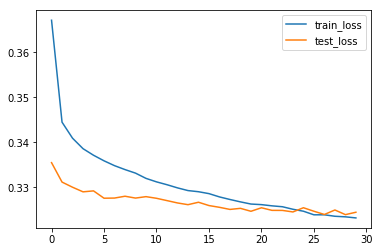

In [13]:
#plotting the losses
plt.plot(epoch_list,train_loss_list)
plt.plot(epoch_list,test_loss_list)
plt.gca().legend(("train_loss","test_loss"))
plt.show()

In [14]:
torch.save(reeds_net.state_dict(),'../trained_networks/reeds_net360_8.pt')